In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats
import itertools
import os
import re
import os.path
import attila_utils
import gem_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
groupdict = {
    'm-control': ('all_control', 'MSBB'),
    'm-AD': ('nosubtyping_AD', 'MSBB'),
    'm-AD-A': ('SubtypeA_AD', 'MSBB'),
    'm-AD-B1': ('SubtypeB1_AD', 'MSBB'),
    'm-AD-B2': ('SubtypeB2_AD', 'MSBB'),
    'm-AD-C1': ('SubtypeC1_AD', 'MSBB'),
    'm-AD-C2': ('SubtypeC2_AD', 'MSBB'),
    'r-control': ('all_control', 'ROSMAP'),
    'r-AD': ('nosubtyping_AD', 'ROSMAP'),
    'r-AD-A': ('SubtypeA_AD', 'ROSMAP'),
    'r-AD-B': ('SubtypeB_AD', 'ROSMAP'),
    'r-AD-C1': ('SubtypeC1_AD', 'ROSMAP'),
    'r-AD-C2': ('SubtypeC2_AD', 'ROSMAP'),
    'r-AD-other': ('Other_AD', 'ROSMAP'),
}
ar = gem_tools.read_active_reactions(groupdict)

In [3]:
col_palette_bar = ['dimgray', '#CFD8DC']
col_palette = col_palette_bar

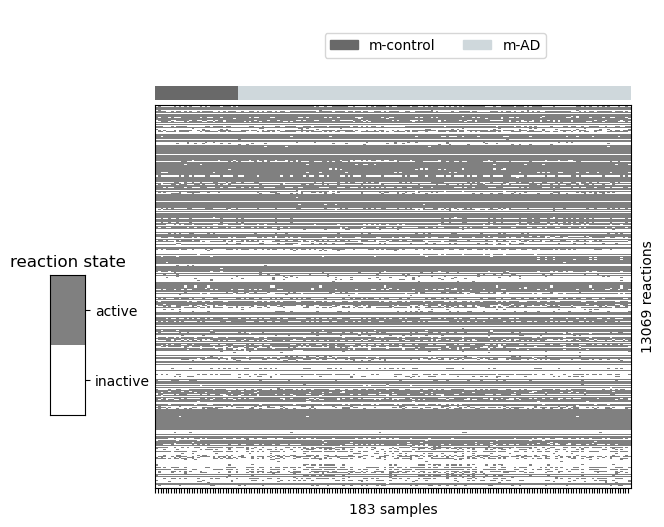

In [4]:
m_ar = {k: v for k, v in ar.items() if k in ['m-control', 'm-AD']}
g = gem_tools.ar_clustermap(None, ar=m_ar, col_palette=col_palette)
attila_utils.savefig(g, 'heatmap-m-control-m-AD')
del g

In [5]:
col_palette_venn = ['dimgray', '#ffb2b2', '#ffecb2','#d8ffb2','#b2ecc5','#b2b2ff']
col_palette_bar = ['dimgray', '#e5fcc2', '#9de0ad', '#45ada8','#547980','#07575b']
col_palette = col_palette_venn

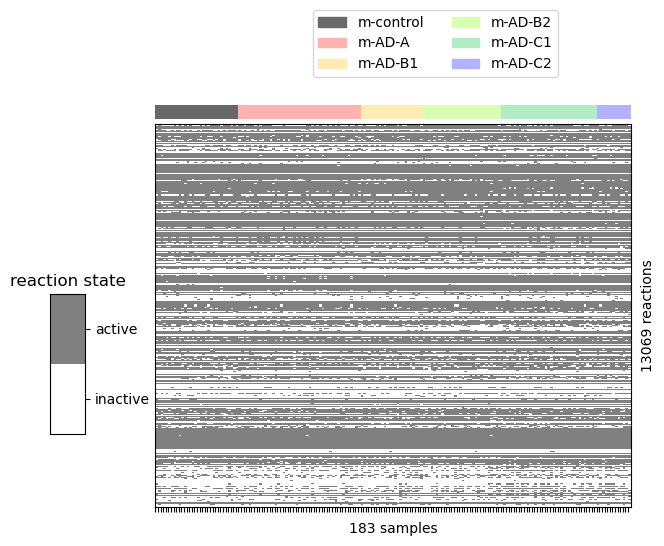

In [6]:
m_ar_sub = {k: v for k, v in ar.items() if k in ['m-control', 'm-AD-A', 'm-AD-B1', 'm-AD-B2', 'm-AD-C1', 'm-AD-C2']}
g = gem_tools.ar_clustermap(None, ar=m_ar_sub, col_palette=col_palette)
attila_utils.savefig(g, 'heatmap-m-control-m-AD-subtypes')
del g

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


['named-figure/rxn-clustermap-m-control-m-AD-subtypes.png',
 'named-figure/rxn-clustermap-m-control-m-AD-subtypes.pdf']

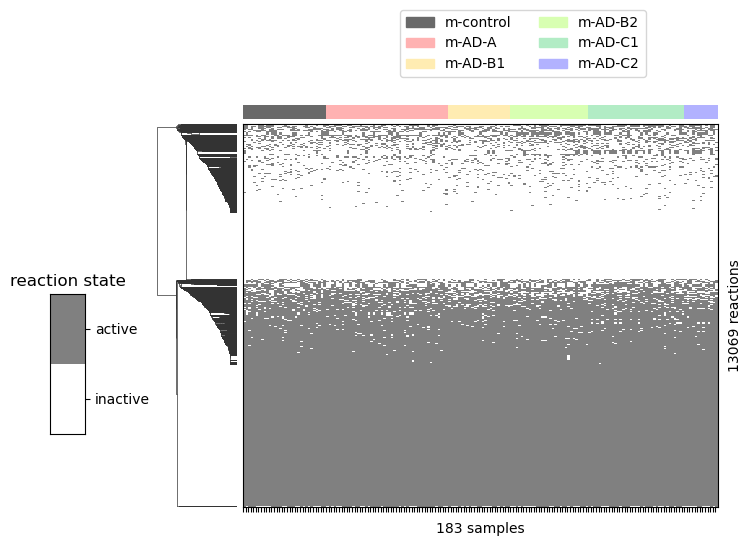

In [7]:
import sys
sys.setrecursionlimit(100000)

g = gem_tools.ar_clustermap(None, ar=m_ar_sub, row_cluster=True, col_palette=col_palette)
attila_utils.savefig(g, 'rxn-clustermap-m-control-m-AD-subtypes')
#del g

['named-figure/rxn-clustermap-m-control-m-AD-subtypes-zoom-260-360.png',
 'named-figure/rxn-clustermap-m-control-m-AD-subtypes-zoom-260-360.pdf']

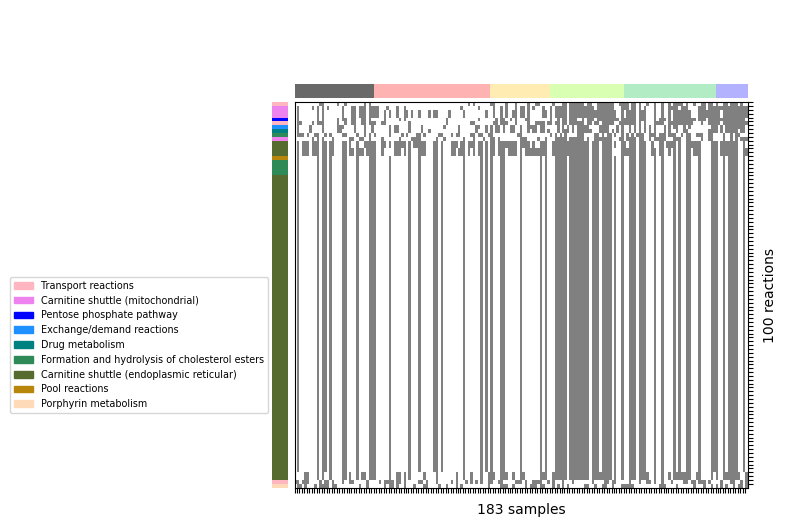

In [8]:
gemsubsys = gem_tools.read_gem_excel()['SUBSYSTEM']

def make_colors_Group(rxn_subsys, min_saturation=0.15):
    t = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in mcolors.CSS4_COLORS.items())
    t = (x for x in t if x[0][1] >= min_saturation)
    colors = list(x[1] for x in t)
    #return(colors)
    n = len(rxn_subsys.unique())
    cmap = pd.Series(colors[:: -np.int16(np.floor(len(colors) / n))][:n], index=rxn_subsys.unique())
    val = rxn_subsys.apply(lambda x: cmap[x]).to_list()
    return((cmap, val))

def zoom_in_clustered_rxn(g, ar, startix, endix, gemsubsys, col_palette=col_palette):
    ar_zoomed = {k: v.iloc[g.dendrogram_row.reordered_ind[startix : endix], :] for k, v in ar.items()}
    rxn_subsys = gemsubsys.loc[ar_zoomed[list(ar_zoomed.keys())[0]].index]
    row_cmap, row_colors = make_colors_Group(rxn_subsys)
    g_zoomed = gem_tools.ar_clustermap(None, ar=ar_zoomed, row_cluster=False, row_colors=row_colors, row_cmap=row_cmap, col_palette=col_palette, draw_cbar=False, draw_col_legend=False)
    #del g_zoomed.ax_cbar
    return(g_zoomed)

g_zoomed = zoom_in_clustered_rxn(g, m_ar_sub, 260, 360, gemsubsys=gemsubsys)
attila_utils.savefig(g_zoomed, 'rxn-clustermap-m-control-m-AD-subtypes-zoom-260-360')

['named-figure/rxn-clustermap-m-control-m-AD-subtypes-zoom-5700-5800.png',
 'named-figure/rxn-clustermap-m-control-m-AD-subtypes-zoom-5700-5800.pdf']

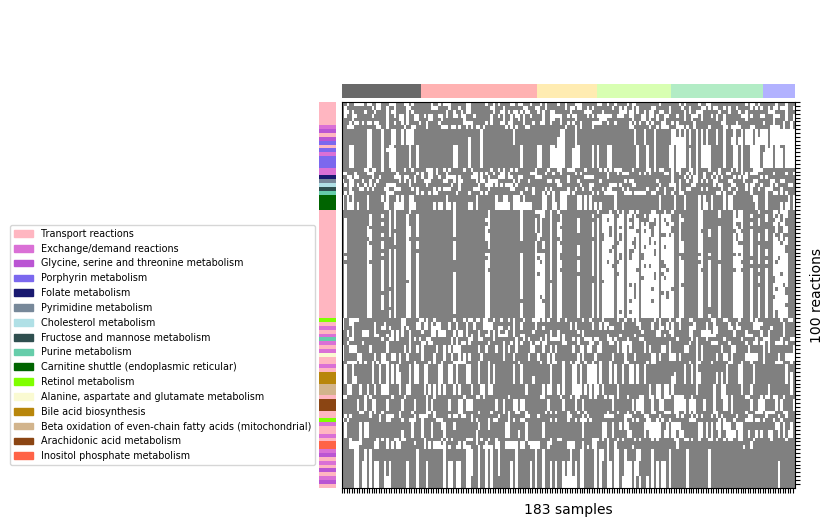

In [9]:
g_zoomed = zoom_in_clustered_rxn(g, m_ar_sub, 5700, 5800, gemsubsys=gemsubsys)
attila_utils.savefig(g_zoomed, 'rxn-clustermap-m-control-m-AD-subtypes-zoom-5700-5800')

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


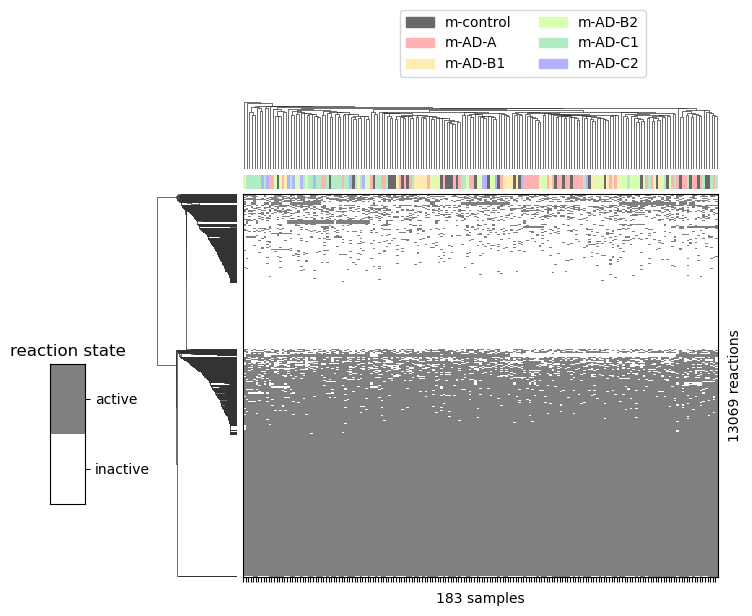

In [10]:
g = gem_tools.ar_clustermap(None, ar=m_ar_sub, row_cluster=True, col_cluster=True, col_palette=col_palette)
attila_utils.savefig(g, 'rxn-subject-clustermap-m-control-m-AD-subtypes')
del g

Next, demonstrate that reaction state is unaffected by subtyping:

In [11]:
def subtype_nosubtype_diff(subtype='m-AD-B2', ar_sub=m_ar_sub, ar0=m_ar):
    group0 = re.sub('-[ABC][12]?$', '', subtype)
    df_sub = ar_sub[subtype]
    df0 = ar0[group0][df_sub.columns]
    key = '∆' + subtype
    value = df_sub ^ df0
    return((key, value))

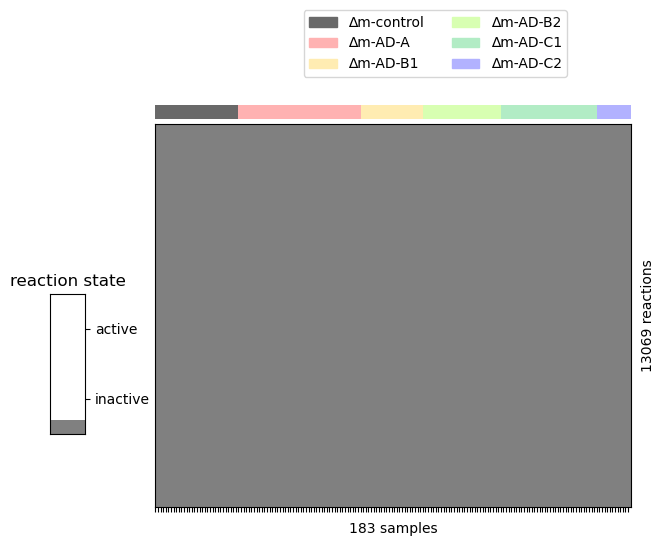

In [12]:
m_ar_sub_diff = dict([subtype_nosubtype_diff(k, m_ar_sub, m_ar) for k in m_ar_sub.keys()])
g = gem_tools.ar_clustermap(None, ar=m_ar_sub_diff, col_cluster=False, col_palette=col_palette)
attila_utils.savefig(g, 'clustermap-m-control-m-AD-subtypes_nosubtyping-diff')
del g

## Similarity of groups (AD subtypes and controls)

Distance between group $A$ and $B$ is defined as the average absolute $\log_2$-odds ratio for $A$ and $B$ taken across all reactions:
\begin{equation}
d(A,B) = m^{-1} \sum_{i=1}^m \bigg | \log_2 \frac{\mathrm{odds}_i(A)}{\mathrm{odds}_i(B)} \bigg |
\end{equation}

In [13]:
def fisher_test(rxn, groupA='m-AD', groupB='m-control', ar=ar, return_odds=True):
    categories = ['active', 'inactive']
    tab = [pd.Categorical(ar[g].loc[rxn].apply(lambda b: 'active' if b else 'inactive').dropna(), categories=categories).value_counts().to_list() for g in [groupA, groupB]]
    res = list(scipy.stats.fisher_exact(tab))#[i]
    return(res)

def get_distance(groupA, groupB, ar=ar, fun=abs, do_write=True):
    if groupA == groupB:
        return(0)
    reactions = ar[list(ar.keys())[0]].index#[-100:]
    l = [fisher_test(r, groupA, groupB) for r in reactions]
    columns = ['oddsratio', 'p_value']
    df = pd.DataFrame(l, columns=columns, index=reactions)
    if do_write:
        comparison = groupA + '_wrt_' + groupB # wrt: with respect to
        fpath = '../../results/2023-02-06-AD-subtypes-active-reactions/' + 'fisher-exact-' + comparison + '.csv'
        df.to_csv(fpath)
    # filter out inf's and nan's
    df = df.applymap(lambda x: np.nan if x in [0, -np.inf, np.inf] else x).dropna()
    # take oddsratio (col 0) for distance calculation
    s = df.iloc[:, 0]
    s = s.apply(lambda x: fun(np.log2(x)))
    distance = s.sum() / len(s)
    return(distance)

In [14]:
K = groupdict.keys()
#argdf = pd.DataFrame([[tuple((a, b)) if i >= j else tuple((None, None)) for i, a in enumerate(K)] for j, b in enumerate(K)], index=K, columns=K)
argdf = pd.DataFrame([[tuple((a, b)) for a in K] for b in K], index=K, columns=K)
argdf

,m-control,m-AD,m-AD-A,m-AD-B1,m-AD-B2,m-AD-C1,m-AD-C2,r-control,r-AD,r-AD-A,r-AD-B,r-AD-C1,r-AD-C2,r-AD-other
m-control,"(m-control, m-control)","(m-AD, m-control)","(m-AD-A, m-control)","(m-AD-B1, m-control)","(m-AD-B2, m-control)","(m-AD-C1, m-control)","(m-AD-C2, m-control)","(r-control, m-control)","(r-AD, m-control)","(r-AD-A, m-control)","(r-AD-B, m-control)","(r-AD-C1, m-control)","(r-AD-C2, m-control)","(r-AD-other, m-control)"
m-AD,"(m-control, m-AD)","(m-AD, m-AD)","(m-AD-A, m-AD)","(m-AD-B1, m-AD)","(m-AD-B2, m-AD)","(m-AD-C1, m-AD)","(m-AD-C2, m-AD)","(r-control, m-AD)","(r-AD, m-AD)","(r-AD-A, m-AD)","(r-AD-B, m-AD)","(r-AD-C1, m-AD)","(r-AD-C2, m-AD)","(r-AD-other, m-AD)"
m-AD-A,"(m-control, m-AD-A)","(m-AD, m-AD-A)","(m-AD-A, m-AD-A)","(m-AD-B1, m-AD-A)","(m-AD-B2, m-AD-A)","(m-AD-C1, m-AD-A)","(m-AD-C2, m-AD-A)","(r-control, m-AD-A)","(r-AD, m-AD-A)","(r-AD-A, m-AD-A)","(r-AD-B, m-AD-A)","(r-AD-C1, m-AD-A)","(r-AD-C2, m-AD-A)","(r-AD-other, m-AD-A)"
m-AD-B1,"(m-control, m-AD-B1)","(m-AD, m-AD-B1)","(m-AD-A, m-AD-B1)","(m-AD-B1, m-AD-B1)","(m-AD-B2, m-AD-B1)","(m-AD-C1, m-AD-B1)","(m-AD-C2, m-AD-B1)","(r-control, m-AD-B1)","(r-AD, m-AD-B1)","(r-AD-A, m-AD-B1)","(r-AD-B, m-AD-B1)","(r-AD-C1, m-AD-B1)","(r-AD-C2, m-AD-B1)","(r-AD-other, m-AD-B1)"
m-AD-B2,"(m-control, m-AD-B2)","(m-AD, m-AD-B2)","(m-AD-A, m-AD-B2)","(m-AD-B1, m-AD-B2)","(m-AD-B2, m-AD-B2)","(m-AD-C1, m-AD-B2)","(m-AD-C2, m-AD-B2)","(r-control, m-AD-B2)","(r-AD, m-AD-B2)","(r-AD-A, m-AD-B2)","(r-AD-B, m-AD-B2)","(r-AD-C1, m-AD-B2)","(r-AD-C2, m-AD-B2)","(r-AD-other, m-AD-B2)"
m-AD-C1,"(m-control, m-AD-C1)","(m-AD, m-AD-C1)","(m-AD-A, m-AD-C1)","(m-AD-B1, m-AD-C1)","(m-AD-B2, m-AD-C1)","(m-AD-C1, m-AD-C1)","(m-AD-C2, m-AD-C1)","(r-control, m-AD-C1)","(r-AD, m-AD-C1)","(r-AD-A, m-AD-C1)","(r-AD-B, m-AD-C1)","(r-AD-C1, m-AD-C1)","(r-AD-C2, m-AD-C1)","(r-AD-other, m-AD-C1)"
m-AD-C2,"(m-control, m-AD-C2)","(m-AD, m-AD-C2)","(m-AD-A, m-AD-C2)","(m-AD-B1, m-AD-C2)","(m-AD-B2, m-AD-C2)","(m-AD-C1, m-AD-C2)","(m-AD-C2, m-AD-C2)","(r-control, m-AD-C2)","(r-AD, m-AD-C2)","(r-AD-A, m-AD-C2)","(r-AD-B, m-AD-C2)","(r-AD-C1, m-AD-C2)","(r-AD-C2, m-AD-C2)","(r-AD-other, m-AD-C2)"
r-control,"(m-control, r-control)","(m-AD, r-control)","(m-AD-A, r-control)","(m-AD-B1, r-control)","(m-AD-B2, r-control)","(m-AD-C1, r-control)","(m-AD-C2, r-control)","(r-control, r-control)","(r-AD, r-control)","(r-AD-A, r-control)","(r-AD-B, r-control)","(r-AD-C1, r-control)","(r-AD-C2, r-control)","(r-AD-other, r-control)"
r-AD,"(m-control, r-AD)","(m-AD, r-AD)","(m-AD-A, r-AD)","(m-AD-B1, r-AD)","(m-AD-B2, r-AD)","(m-AD-C1, r-AD)","(m-AD-C2, r-AD)","(r-control, r-AD)","(r-AD, r-AD)","(r-AD-A, r-AD)","(r-AD-B, r-AD)","(r-AD-C1, r-AD)","(r-AD-C2, r-AD)","(r-AD-other, r-AD)"
r-AD-A,"(m-control, r-AD-A)","(m-AD, r-AD-A)","(m-AD-A, r-AD-A)","(m-AD-B1, r-AD-A)","(m-AD-B2, r-AD-A)","(m-AD-C1, r-AD-A)","(m-AD-C2, r-AD-A)","(r-control, r-AD-A)","(r-AD, r-AD-A)","(r-AD-A, r-AD-A)","(r-AD-B, r-AD-A)","(r-AD-C1, r-AD-A)","(r-AD-C2, r-AD-A)","(r-AD-other, r-AD-A)"


In [15]:
def get_distance_matrix(ar=ar, fun=abs):
    fpath = '../../results/2023-02-06-AD-subtypes-active-reactions/subtype-distances.csv'
    if os.path.exists(fpath):
        print('Reading file from disk...')
        dm = pd.read_csv(fpath, index_col=0)
    else:
        print('Calculating distances...')
        dm = argdf.applymap(lambda t: get_distance(*t, ar=ar, fun=fun))
        dm.to_csv(fpath)
    return(dm)

dm = get_distance_matrix(ar=ar, fun=abs)

Reading file from disk...


/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


['named-figure/distance-matrix-subtypes-cohorts.png',
 'named-figure/distance-matrix-subtypes-cohorts.pdf']

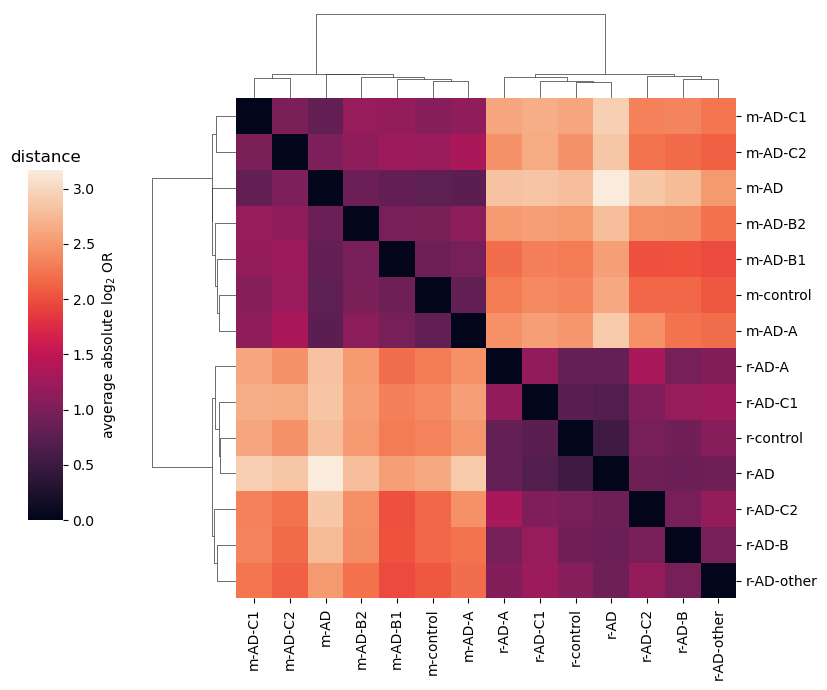

In [16]:
g = sns.clustermap(dm, figsize=(7,7), dendrogram_ratio=0.15, cbar_kws={'orientation': 'vertical'})
g.ax_cbar.set_position((-0.15, 0.25, 0.05, 0.5))
g.ax_cbar.set_ylabel(r'avgerage absolute $\log_2$ OR')
g.ax_cbar.set_title('distance')
attila_utils.savefig(g, 'distance-matrix-subtypes-cohorts')

## Genome-wide significance

In [17]:
gem = gem_tools.read_gem_excel(usecols=['ID', 'SUBSYSTEM', 'EQUATION'])
sel_groups = ['m-AD', 'm-AD-B2']
fpaths = ['../../results/2023-02-06-AD-subtypes-active-reactions/fisher-exact-' + group + '_wrt_m-control.csv' for group in sel_groups]
l = [pd.read_csv(fpath, index_col='rxn_ID').rename({'oddsratio': 'oddsratio_' + group, 'p_value': 'p_value_' + group}, axis=1) for fpath, group in zip(fpaths, sel_groups)]
fisher = pd.concat([gem] + l, axis=1)
del gem, l
fisher.to_csv('../../results/2023-02-06-AD-subtypes-active-reactions/fisher.csv')
fisher.sort_values('p_value_m-AD-B2')

,EQUATION,SUBSYSTEM,oddsratio_m-AD,p_value_m-AD,oddsratio_m-AD-B2,p_value_m-AD-B2
MAR00139,"L-carnitine[x] + 4,8-Dimethylnonanoyl Coenzyme...",Fatty acid oxidation,4.504854,0.009073,31.761905,7.185990e-08
MAR07674,glucose[g] + UDP-galactose[g] => H+[g] + lacto...,Galactose metabolism,1.958333,0.200436,21.666667,5.792714e-07
MAR01476,lactose[g] => lactose[e],Transport reactions,1.958333,0.200436,21.666667,5.792714e-07
MAR04615,GDP[c] + thioredoxin[c] => dGDP[c] + H2O[c] + ...,Purine metabolism,0.280488,0.003210,0.051282,9.278541e-07
MAR06308,arginine[c] + ornithine[m] + H+[i] => arginine...,Transport reactions,0.549708,0.223096,0.066667,4.195629e-06
...,...,...,...,...,...,...
MAR06434,9-carboxy-alpha-tocotrienol[m] + ATP[m] + CoA[...,Vitamin E metabolism,NaN,1.000000,NaN,1.000000e+00
MAR06435,7-carboxy-alpha-tocotrienol[m] + ATP[m] + CoA[...,Vitamin E metabolism,NaN,1.000000,NaN,1.000000e+00
MAR06436,5-carboxy-alpha-chromanol[m] + ATP[m] + CoA[m]...,Vitamin E metabolism,NaN,1.000000,NaN,1.000000e+00
MAR06426,alpha-tocotrienol[c] + H+[c] + NADPH[c] + O2[c...,Vitamin E metabolism,NaN,1.000000,NaN,1.000000e+00


['named-figure/volcano-m-AD_m-AD-B2.png',
 'named-figure/volcano-m-AD_m-AD-B2.pdf']

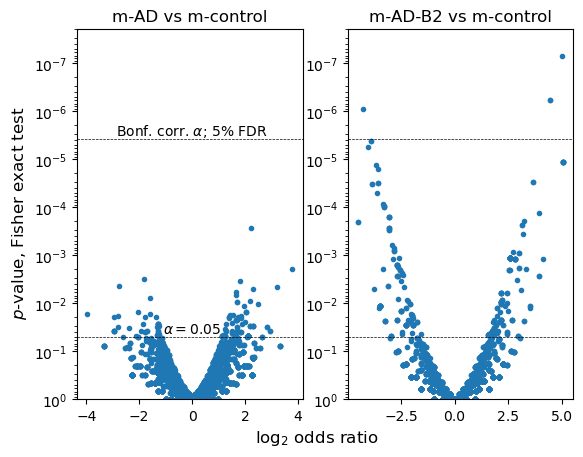

In [18]:
def volcano(group, ax, fisher=fisher, alpha=0.05, text_bonf=False):
    OR_col, pval_col = [s + group for s in ['oddsratio_', 'p_value_']]
    df = fisher.copy()
    df['log2 OR'] = df[OR_col].apply(np.log2)
    ax.scatter(x='log2 OR', y=pval_col, data=df, marker='.')
    bonf_alpha = alpha / df.shape[0]
    if text_bonf:
        s = r'Bonf. corr. $\alpha$; ' + str(int(100 * alpha)) + '% FDR'
        ax.text(x=0, y=bonf_alpha, s=s, horizontalalignment='center', verticalalignment='bottom')
        ax.text(x=0, y=alpha, s=r'$\alpha = $' + str(alpha), horizontalalignment='center', verticalalignment='bottom')
    ax.axhline(bonf_alpha, linestyle='dashed', color='black', linewidth=0.5)
    ax.axhline(alpha, linestyle='dashed', color='black', linewidth=0.5)
    ax.set_yscale('log')
    ax.set_ylim([2e-8, 1])
    ax.invert_yaxis()
    ax.set_title(group + ' vs m-control')
    return(ax)

fig, ax = plt.subplots(1, 2, sharey=False)
for i, x in enumerate(zip(['m-AD', 'm-AD-B2'], ax)):
    group, axi = x
    axi = volcano(group, axi, text_bonf=i == 0)
fig.supxlabel(r'$\log_2$ odds ratio')
fig.supylabel(r'$p$-value, Fisher exact test')
attila_utils.savefig(fig, 'volcano-m-AD_m-AD-B2')

['named-figure/altered-vs-all-reactions-in-subsystems-m-AD-B2.png',
 'named-figure/altered-vs-all-reactions-in-subsystems-m-AD-B2.pdf']

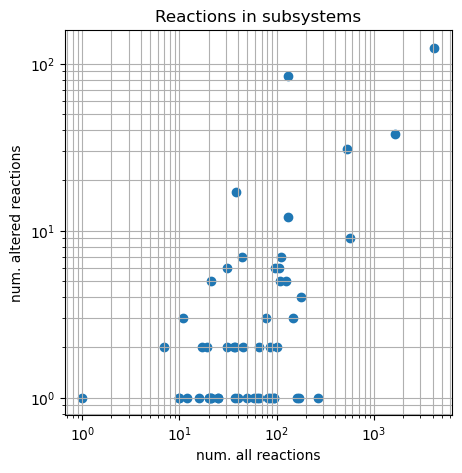

In [19]:
def get_num_altered_rxn(group='m-AD-B2'):
    sy = fisher.groupby('SUBSYSTEM')['p_value_' + group].apply(lambda s: s.apply(lambda p: p <= 0.05).sum())
    sx = fisher.value_counts('SUBSYSTEM')
    df = pd.concat([sx.to_frame('num. all reactions'), sy.to_frame('num. altered reactions')], axis=1)
    return(df)

sel_groups = ['m-AD-B2']
fig, ax = plt.subplots(figsize=(5, 5))
for group in sel_groups:
    ax.scatter(x='num. all reactions', y='num. altered reactions', data=get_num_altered_rxn(group=group), marker='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(axis='both', which='both')
ax.set_xlabel('num. all reactions')
ax.set_ylabel('num. altered reactions')
ax.set_title('Reactions in subsystems')
attila_utils.savefig(fig, 'altered-vs-all-reactions-in-subsystems-m-AD-B2')

In [20]:
%connect_info

{
  "shell_port": 59599,
  "iopub_port": 59600,
  "stdin_port": 59601,
  "control_port": 59603,
  "hb_port": 59602,
  "ip": "127.0.0.1",
  "key": "19ea76e6-f9c17b8e30d8ff19b91e1621",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-3d5c8c5f-c4d1-427c-bab5-aa433998abcf.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
